In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import Counter

import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Using TensorFlow backend.


In [2]:
# importing data
df = pd.read_hdf('../car.h5')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106494 entries, 0 to 160615
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 77.0+ MB


In [3]:
# settings changed so all data will be displayed
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
df.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False

In [4]:
# Target variable (car price) has two currencies
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [6]:
# normalizing target variable to one currency using function shown above

def normalize_price_value(x):
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5
    
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

Text(0.5, 1.0, 'price_value_PLN_log')

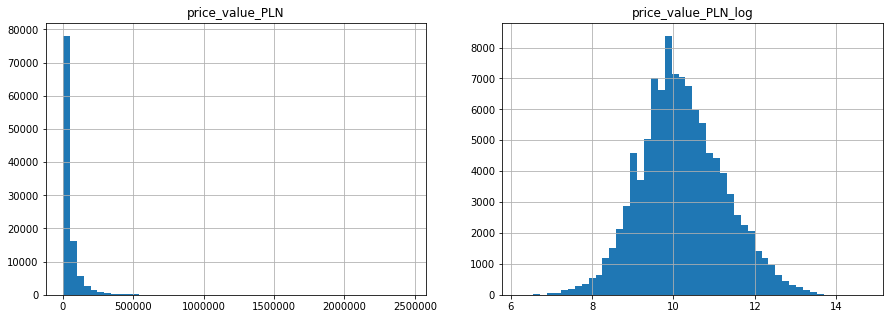

In [7]:
# It seems that sing logarithm of target variable is worth looking into

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['price_value_PLN'].hist(bins=50);
plt.title('price_value_PLN')
plt.subplot(1,2,2)
np.log1p(df['price_value_PLN']).hist(bins=50);
plt.title('price_value_PLN_log')

In [8]:
# logarithmic target variable is created
df['price_value_PLN_log'] = np.log1p(df['price_value_PLN'])

In [9]:
# all missing data is replaced with -1
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

5832640


0

In [10]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

In [11]:
def get_X_y_and_cros_val(model, feats, log=False): # cross validation with option to use logarithmic target variable
    
    X = df[ feats ].values
    y = df['price_value_PLN'].values if not log else df['price_value_PLN_log'].values
    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        
        
        y_pred = train_model.predict(X[test_idx])
        y_pred = np.expm1(y_pred) if log else y_pred
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    return scores, np.std(scores)

In [12]:
# Dummy model for reference
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

39702.02572163561

# feature engineering 

In [13]:
# all sets of features will be tested on the same model:
model = DecisionTreeRegressor(max_depth=5, random_state=0)

In [14]:
# first try: only bool features since it requiers no additional work
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

In [15]:
# original target variable
get_X_y_and_cros_val(model, feats, log=False)

([25076.606847115643, 24909.340696410825, 24992.17567774242],
 68.28715648360107)

In [16]:
#logarithmic target variable. Unfortunately score has worsen, will be double checked later.
get_X_y_and_cros_val(model, feats, log=True)

([37271.07676178811, 37203.219877094125, 37630.83489943696],
 187.64182243430503)

In [17]:
df.select_dtypes([np.object]).sample(20)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
139254,"[Osobowe, Jeep, Grand Cherokee, Jeep Grand Che...","13:05, 5 marca 2018",PLN,"Cena Brutto, Faktura VAT","Mełgiewska 10 - 20-209 Lublin, Lubelskie (Polska)",Fix Forum Lider Sp. z o.o.,Dealer,-1,-1,Jeep,-1,-1,-1,-1,-1,-1,-1,5 km,Tak,2017,1C4RJFBM3JC218411,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,Tak,-1,-1,4x4 (stały),-1,SUV,-1,-1,"Automatyczna dwusprzęgłowa (DCT, DSG)",-1,-1,-1,-1,-1,Firmy,250 KM,-1,-1,-1,-1,-1,Diesel,Tak,-1,-1,-1,-1,-1,-1,Grand Cherokee,2 998 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Nowe,IV (2010-),-1,-1,-1,Tak,-1,-1
85894,"[Osobowe, Audi, Q5, Audi Q5 8R (2008-2016)]","22:33, 2 marca 2018",PLN,"Cena Brutto, Do negocjacji","Bydgoszcz, Kujawsko-pomorskie",-1,Osoba prywatna,5,-1,Audi,-1,-1,4,-1,-1,-1,-1,68 523 km,-1,2013,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,-1,-1,SUV,-1,Tak,Automatyczna hydrauliczna (klasyczna),-1,-1,-1,-1,Tak,Osoby prywatnej,211 KM,-1,-1,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,Q5,1 998 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,8R (2008-2016),-1,-1,-1,-1,-1,-1
64662,"[Osobowe, Toyota, Auris, Toyota Auris II (2012-)]","13:14, 28 lutego 2018",PLN,"Cena Brutto, Do negocjacji","ul. Morska 212 A - 81-006 Gdynia, Chylonia (Po...",F.H.U. VERSUS S.C. Dealer Samochodów Używanych...,Dealer,5,-1,Toyota,-1,-1,5,-1,-1,-1,-1,50 000 km,-1,2014,-1,-1,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,Tak,-1,-1,Na przednie koła,-1,Kombi,Tak,Tak,Automatyczna bezstopniowa (CVT),-1,-1,-1,-1,Tak,Firmy,136 KM,-1,Polska,-1,-1,Tak,Hybryda,Tak,-1,-1,-1,-1,-1,-1,Auris,1 800 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Biały,-1,-1,Używane,II (2012-),-1,-1,-1,Tak,-1,-1
110876,"[Osobowe, Fiat, Punto Evo]","17:29, 28 lutego 2018",PLN,"Cena Brutto, Do negocjacji","Modliszewko, gnieźnieński, Wielkopolskie",-1,Osoba prywatna,5,-1,Fiat,-1,-1,3,-1,-1,-1,-1,129 350 km,-1,2008,-1,-1,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Auta miejskie,-1,Tak,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,140 KM,-1,Niemcy,-1,-1,Tak,Benzyna,Tak,-1,-1,-1,-1,-1,-1,Punto Evo,1 400 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Biały,-1,-1,Używane,-1,-1,-1,-1,Tak,Tak,-1
76279,"[Osobowe, Renault, Koleos]","23:01, 1 marca 2018",PLN,"Cena Brutto, Do negocjacji","MŁYNARSKA 6 - 43-600 Jaworzno, Śląskie (Polska)",''QUATRO'',Dealer,5,-1,Renault,-1,-1,5,-1,-1,-1,-1,182 500 km,-1,2010,-1,Tak,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,-1,-1,-1,4x4 (stały),-1,SUV,-1,-1,Manualna,-1,-1,-1,-1,-1,Firmy,150 KM,-1,-1,-1,-1,Tak,Diesel,-1,-1,-1,-1,-1,-1,-1,Koleos,2 000 

In [18]:
# features worth merging (chosen after feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year',
           'param_rodzaj-paliwa': 'param_fuel-type',
           'param_moc': 'param_engine-power',
           'param_marka-pojazdu': 'param_make',
           'param_napęd': 'param_transmission',
           'param_skrzynia-biegów': 'param_gearbox'
          }

# numerical features
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date features
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja']

# blacklist features will not be used
black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency', 'price_value', 'price_value_PLN', 'price_value_PLN_log']

###### Mearging columns

In [19]:
# Function used to find columns carrying the same information (used on columns picked after feature importance check)
val_to_check = 'Manualna'
for column in df.columns:
    occurrences = (df[column] == val_to_check).sum()
    if occurrences > 0:
        print('occurrences of {} in {}: {}'.format(val_to_check, column, occurrences))

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


occurrences of Manualna in param_gearbox: 53
occurrences of Manualna in param_skrzynia-biegów: 73420


In [20]:
df['param_skrzynia-biegów'].unique()

array(['Manualna', 'Automatyczna hydrauliczna (klasyczna)',
       'Automatyczna dwusprzęgłowa (DCT, DSG)', -1,
       'Automatyczna bezstopniowa (CVT)',
       'Półautomatyczna (ASG, Tiptronic)'], dtype=object)

In [21]:
def check_if_complementing(feat1, feat2): # count of instances when data only in one of the columns
    has_data = {feat1: 0 , feat2: 0, 'both': 0}
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data['both'] += 1         
        elif df[feat1].iloc[i] != -1:
            has_data[feat1] += 1  
        elif df[feat2].iloc[i] != -1:
            has_data[feat2] += 1  
    print(has_data)

In [22]:
# before merging columns were checked if they contain data that is complementary or just duplicates
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)
    print()

{'param_liczba-drzwi': 96594, 'param_door-count': 74, 'both': 0}

{'param_przebieg': 106057, 'param_mileage': 82, 'both': 0}

{'param_pojemność-skokowa': 101389, 'param_engine-capacity': 79, 'both': 0}

{'param_emisja-co2': 2086, 'param_co2-emissions': 3, 'both': 0}

{'param_rok-produkcji': 106302, 'param_year': 83, 'both': 0}

{'param_rodzaj-paliwa': 106302, 'param_fuel-type': 83, 'both': 0}

{'param_moc': 97009, 'param_engine-power': 75, 'both': 0}

{'param_marka-pojazdu': 106302, 'param_make': 83, 'both': 0}

{'param_napęd': 90084, 'param_transmission': 69, 'both': 0}

{'param_skrzynia-biegów': 100676, 'param_gearbox': 77, 'both': 0}



In [23]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]

In [24]:
# merge data in 'doubles' dictionary
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)

###### Caterogical features

In [25]:
# picking categorical features form df
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]

# using factorize on categorical features
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

In [27]:
# model trained with bool and categorical features. Score improved.
feats = list(bool_feats) + list(cat_feats)
get_X_y_and_cros_val(model, feats)

([20213.80365092535, 20364.769520262143, 20327.6146409624], 64.22540187461803)

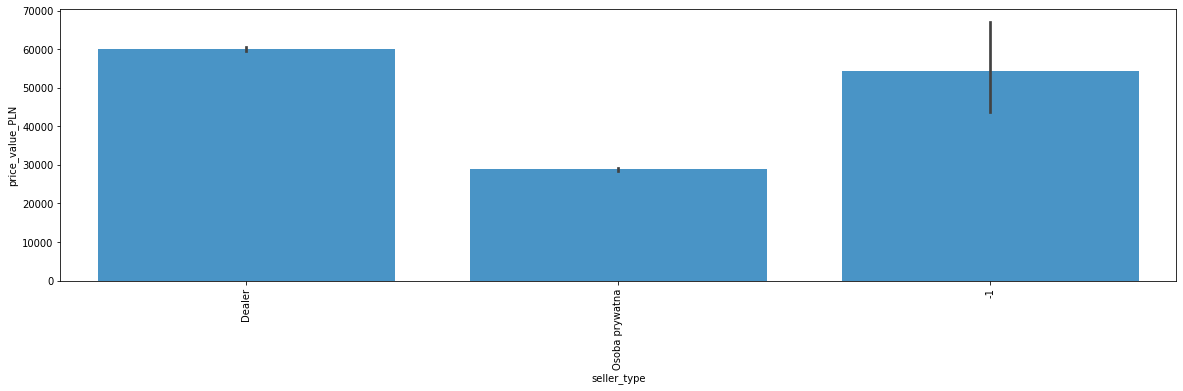

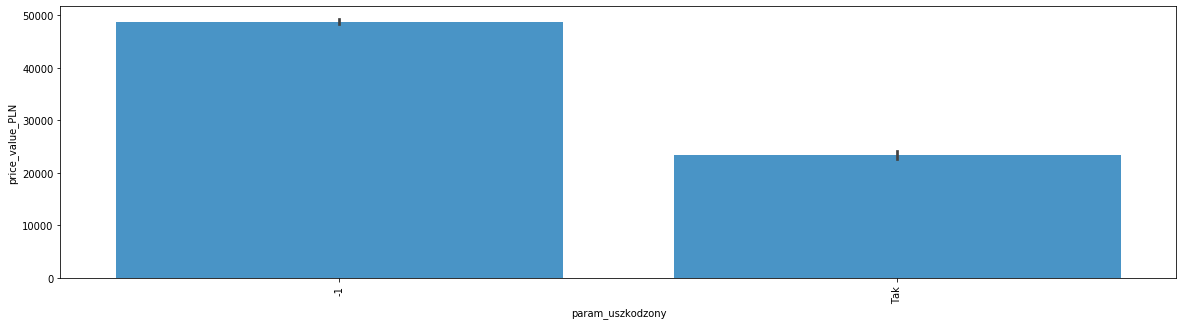

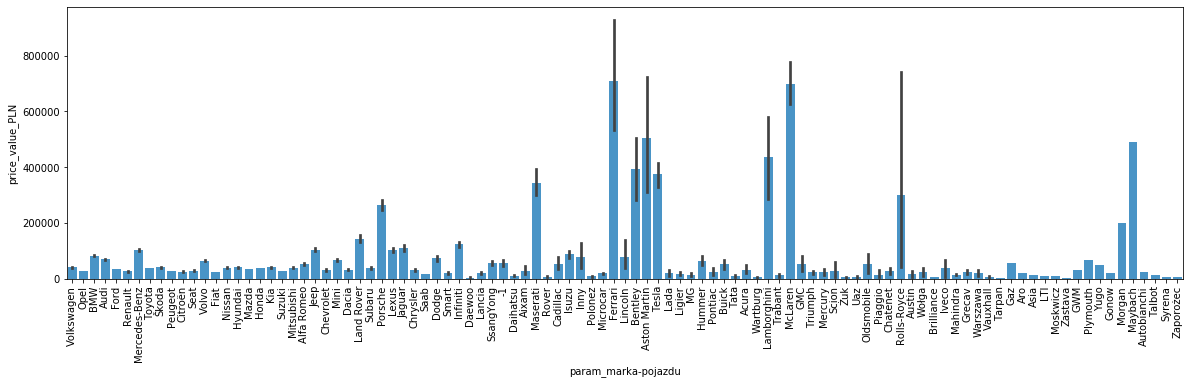

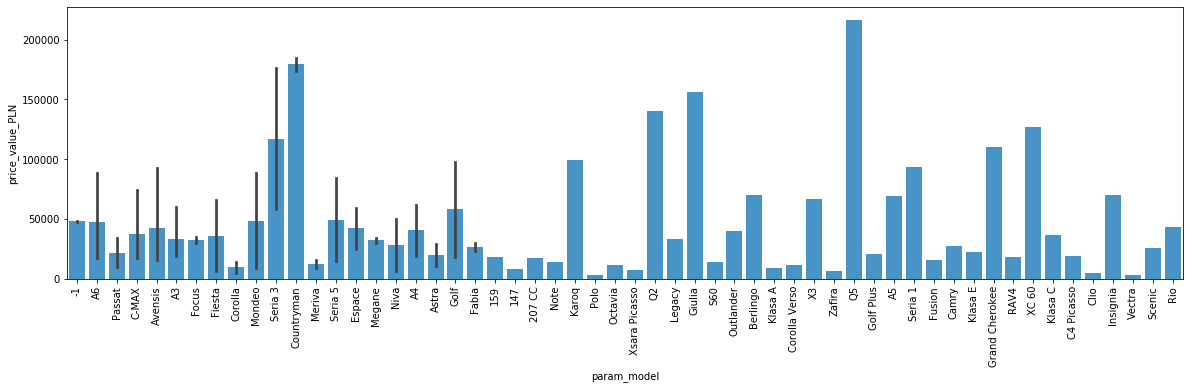

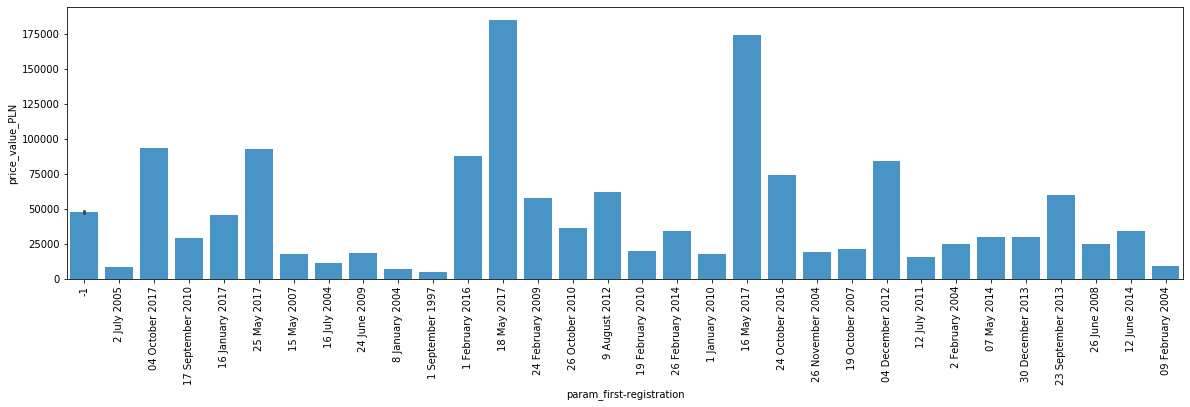

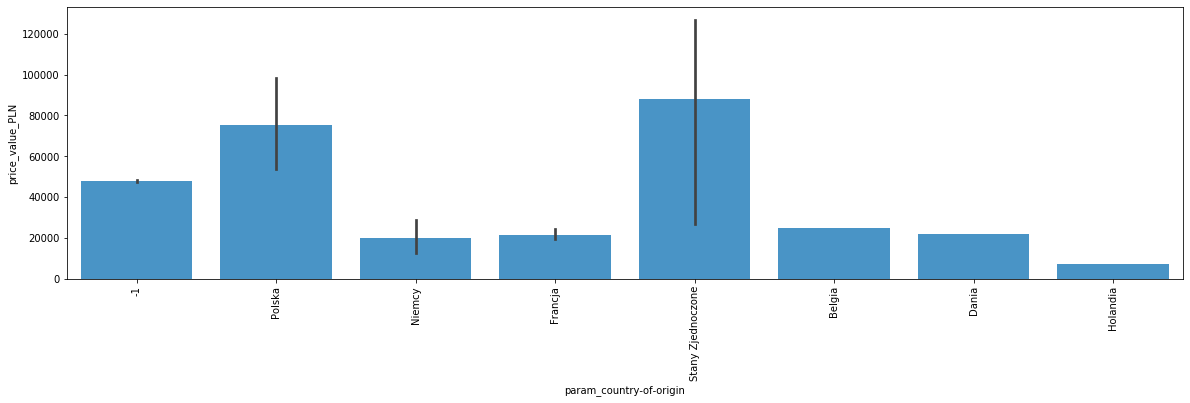

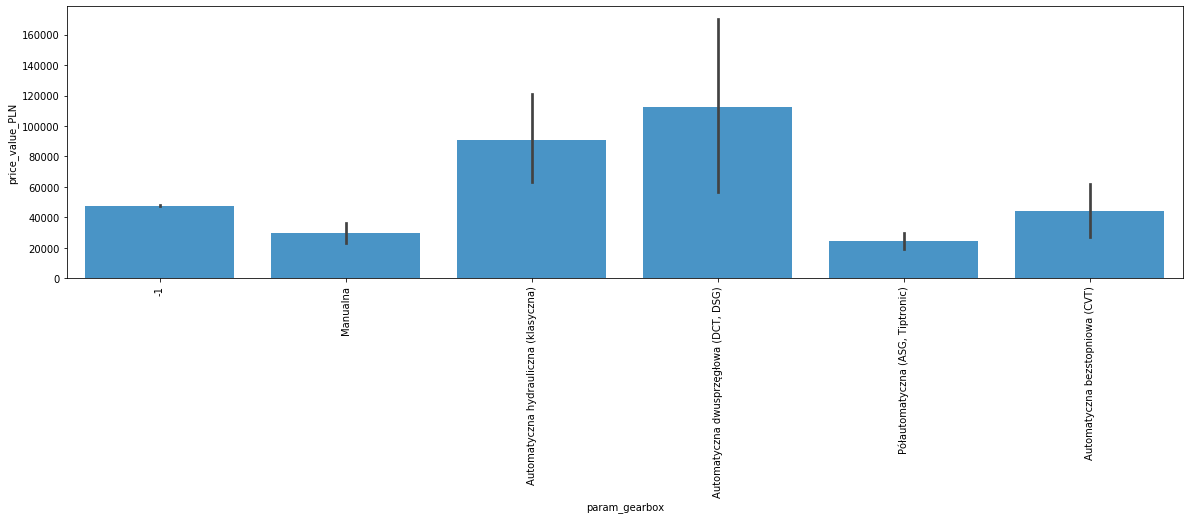

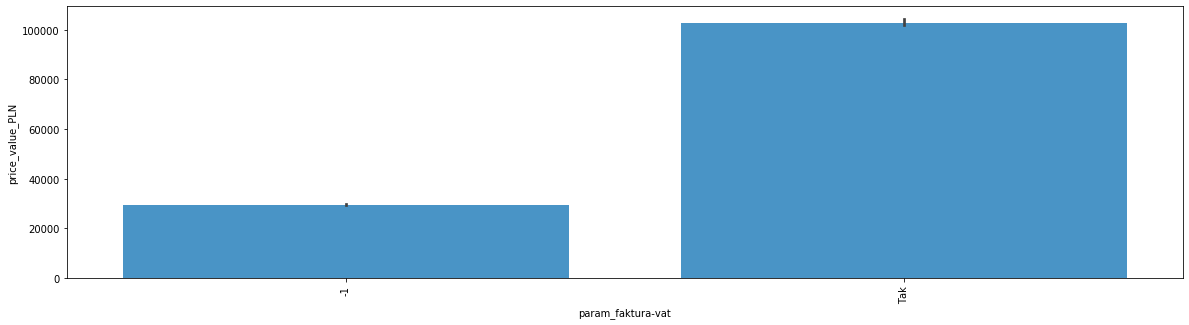

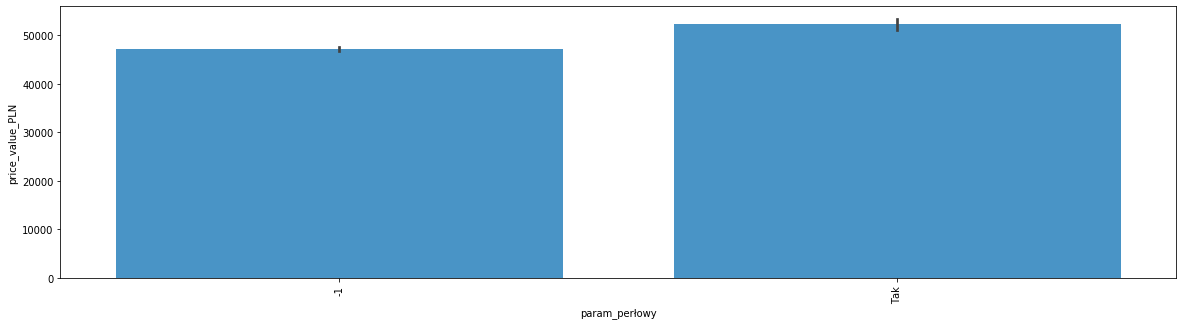

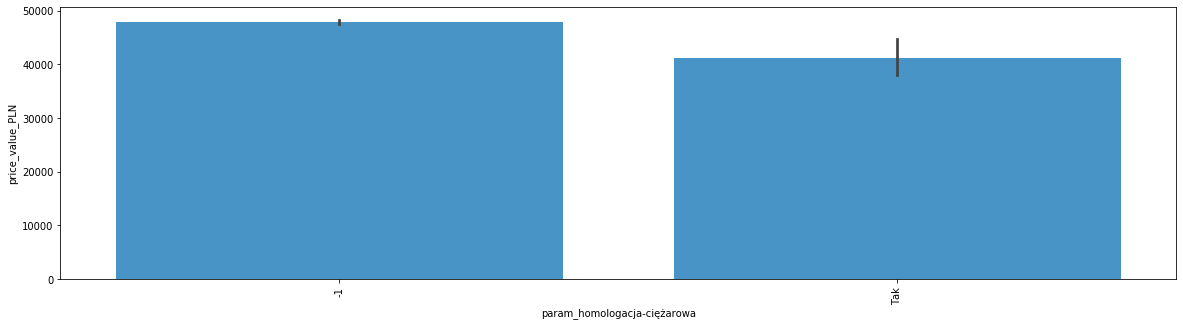

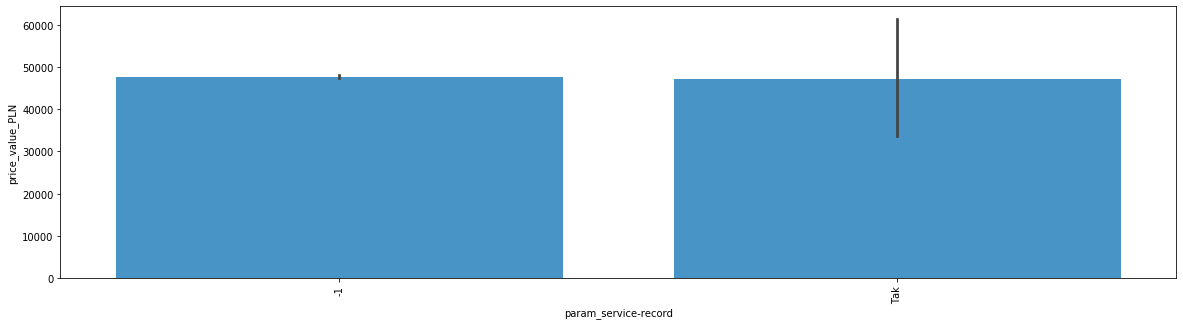

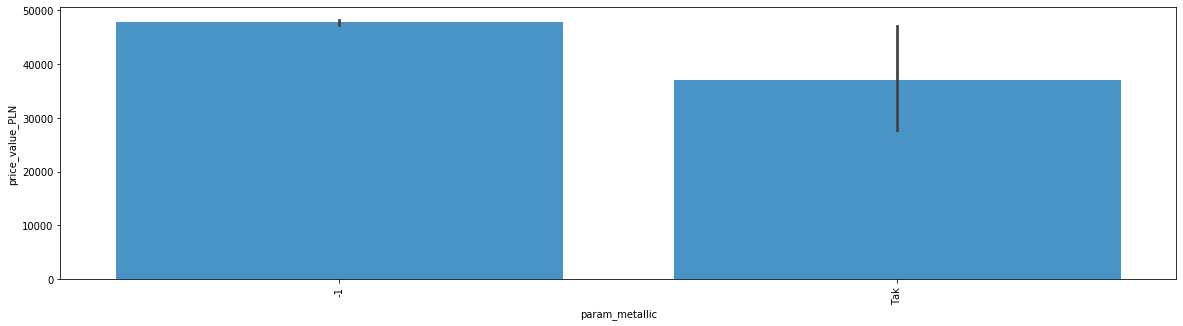

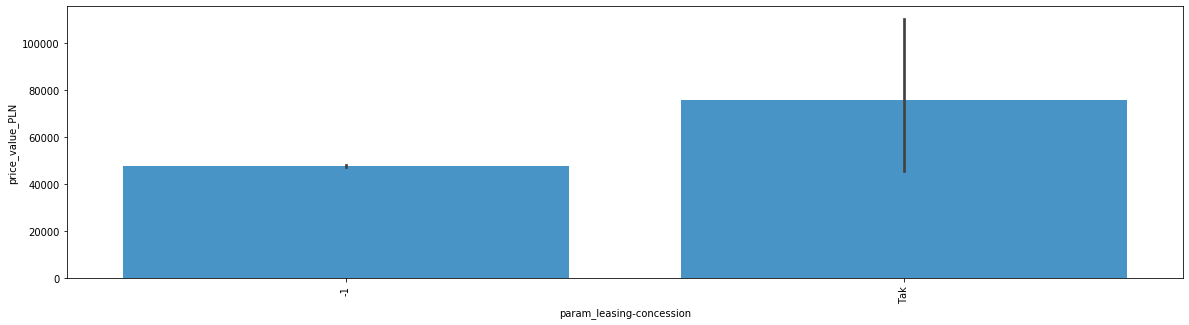

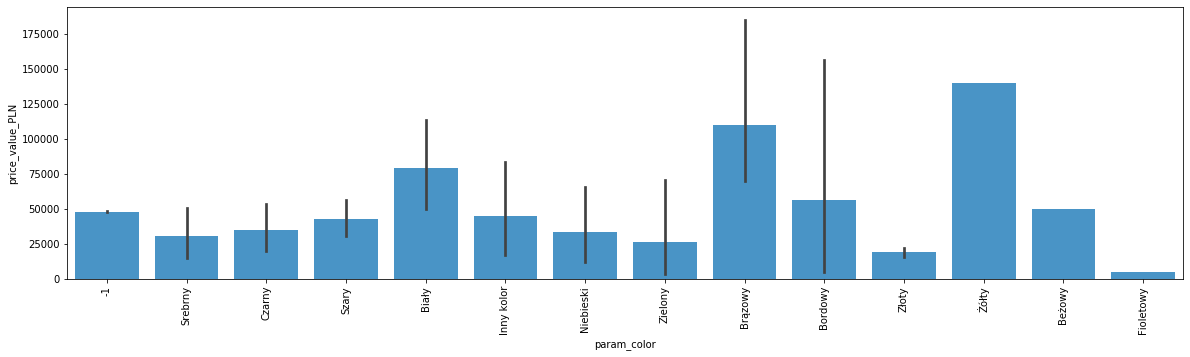

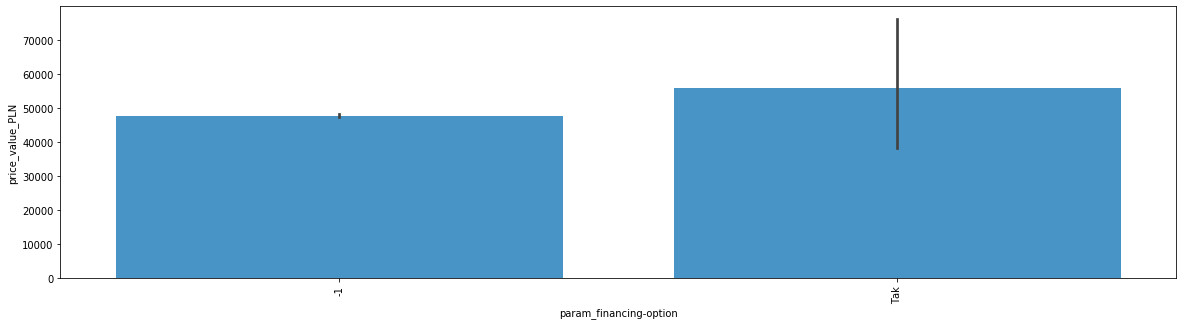

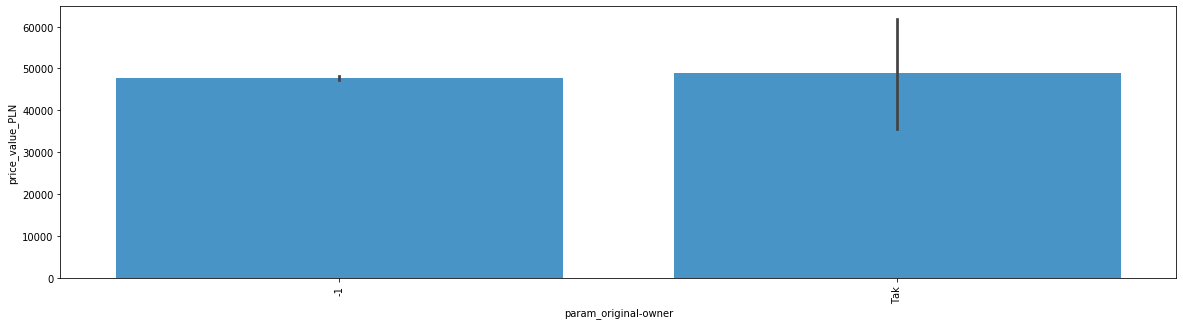

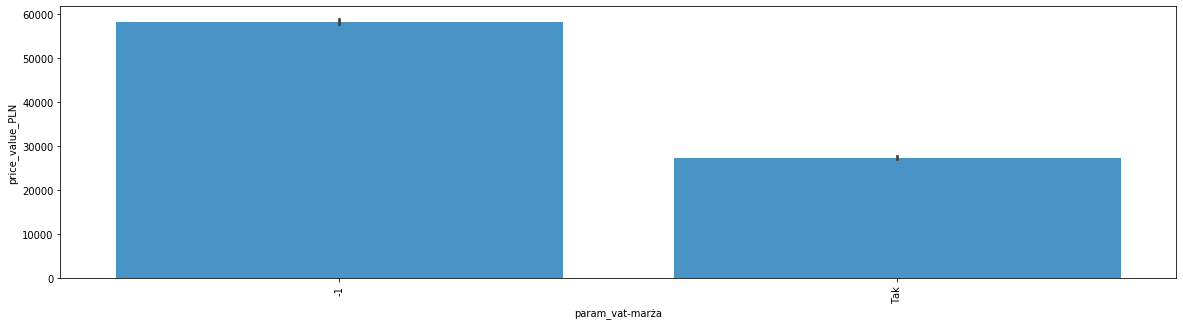

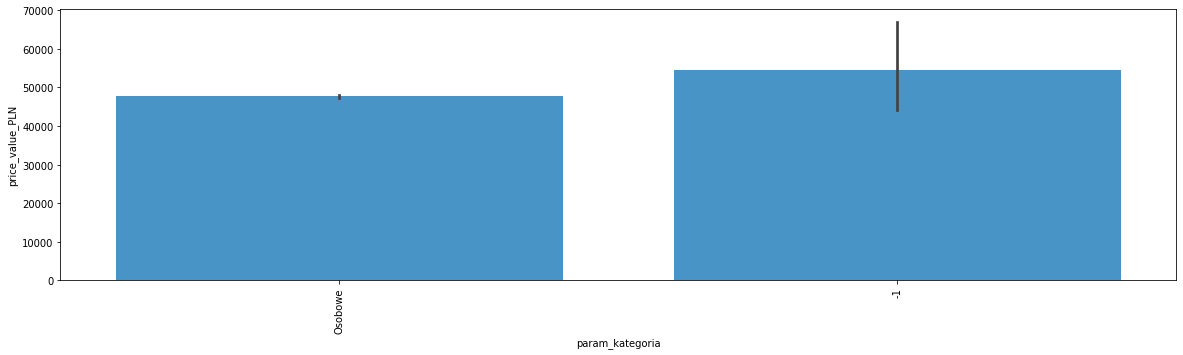

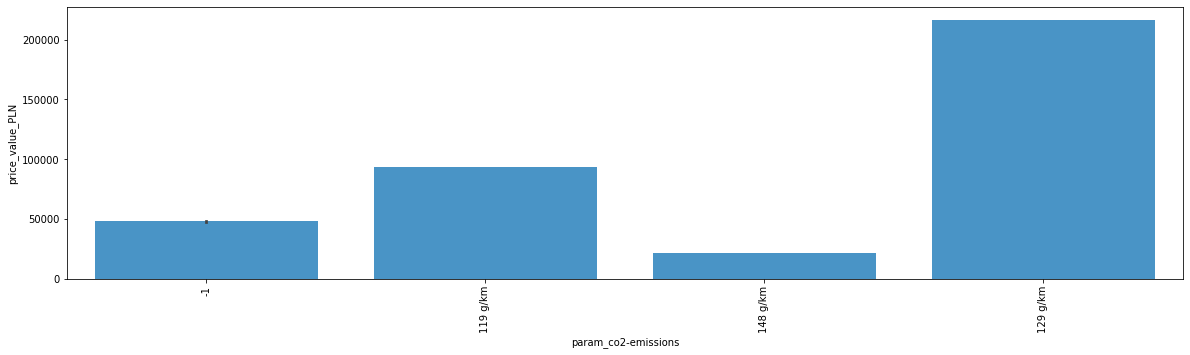

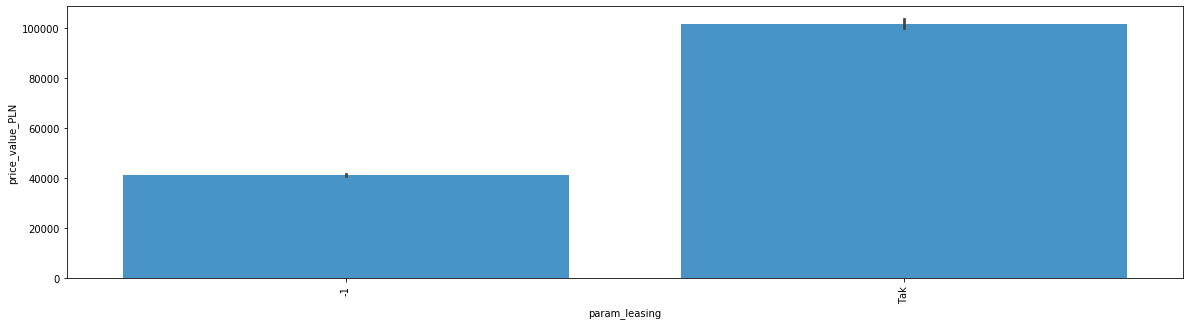

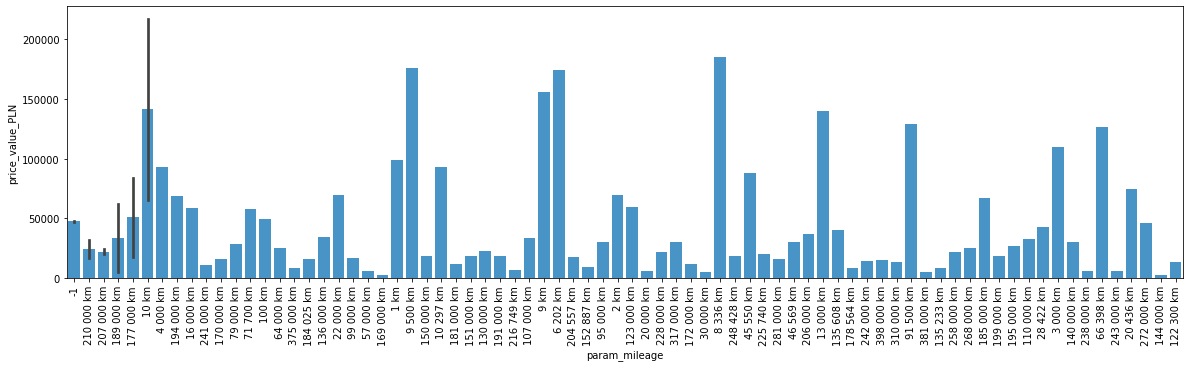

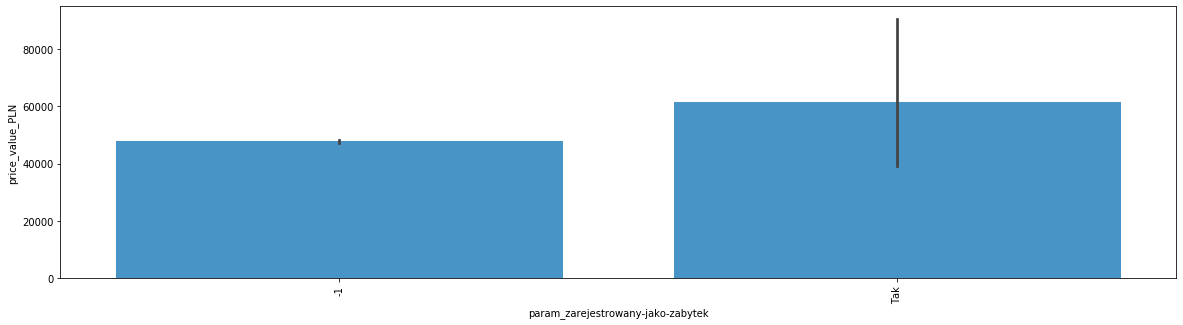

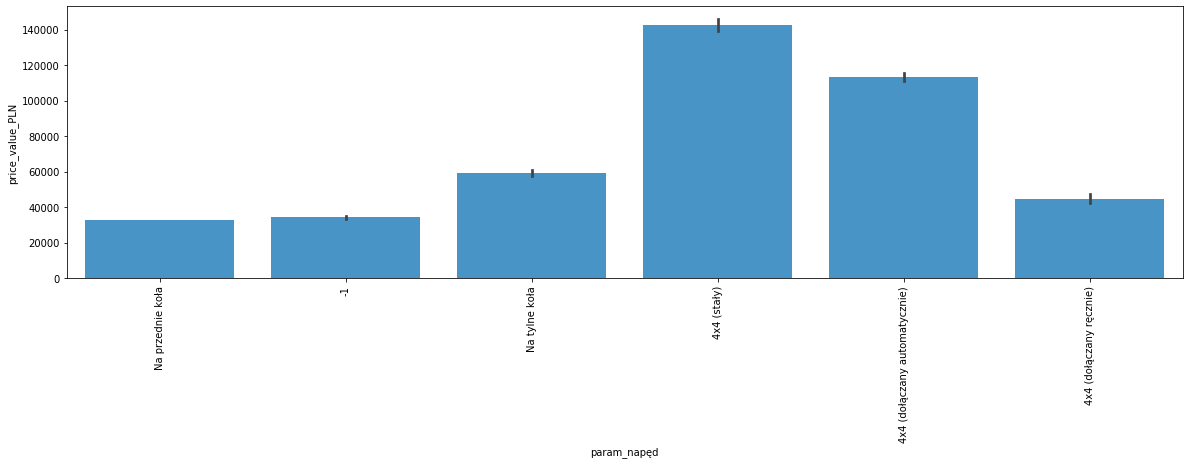

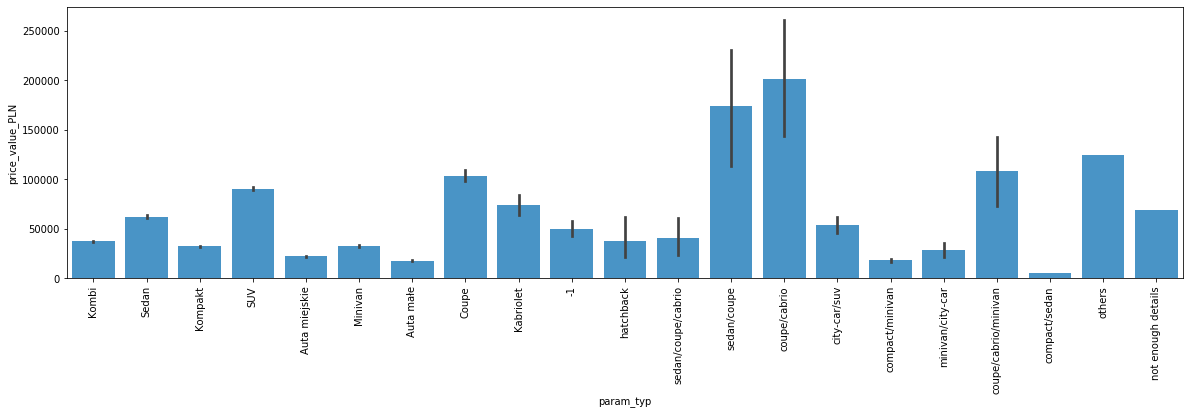

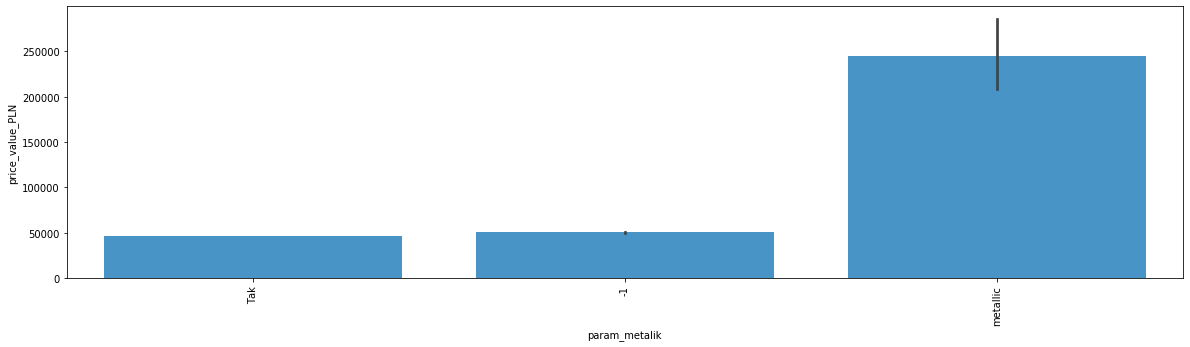

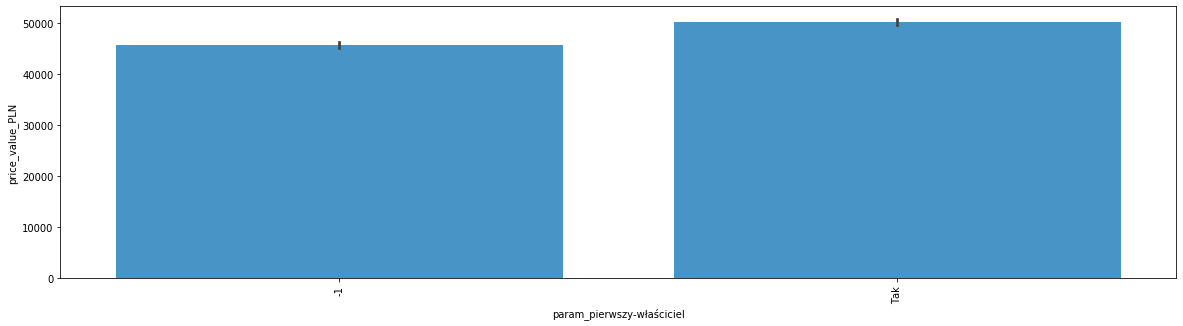

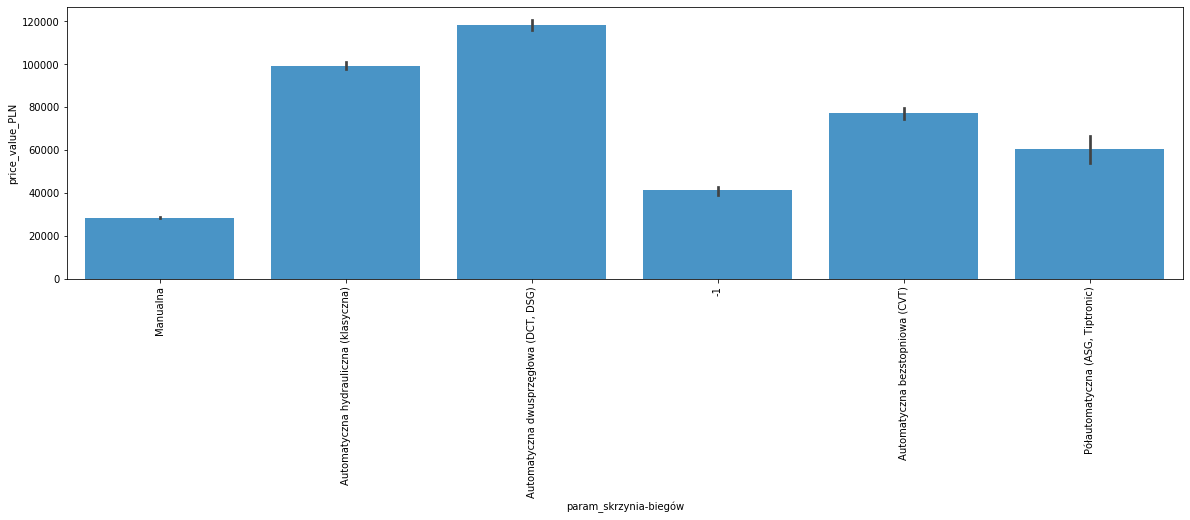

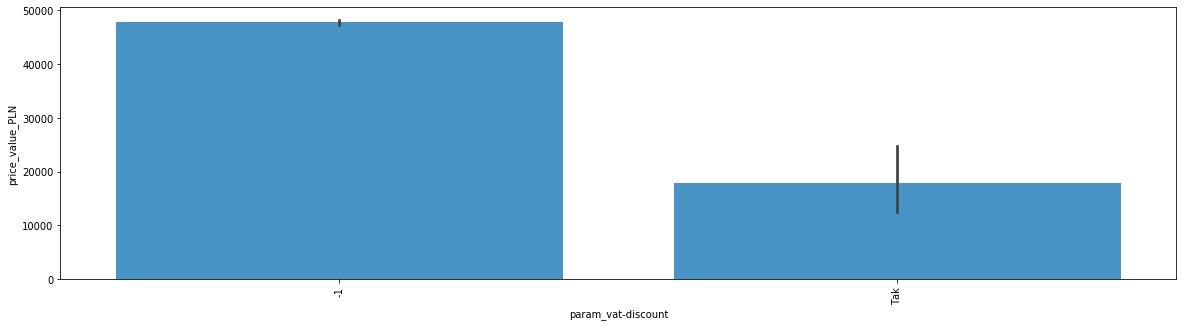

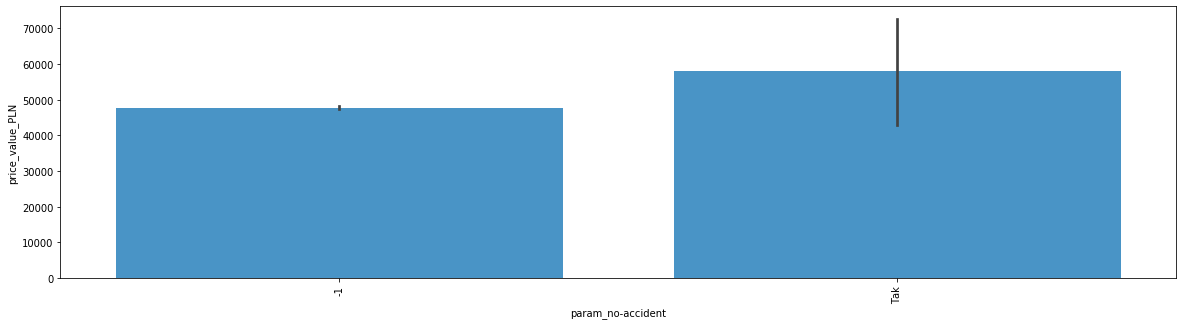

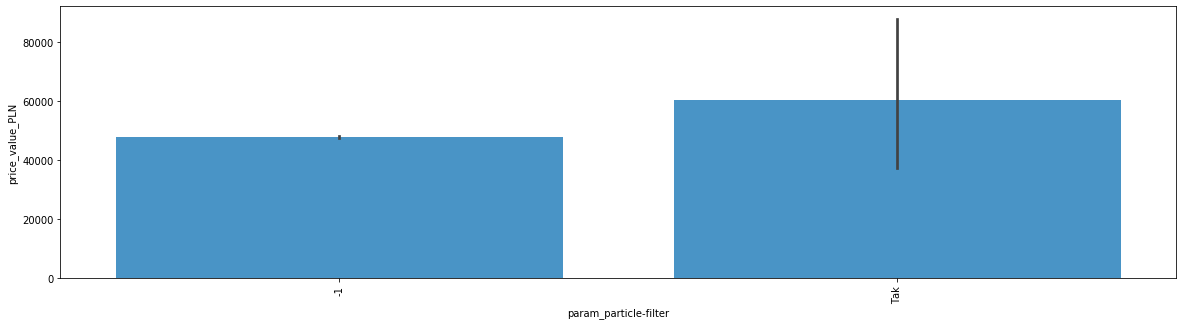

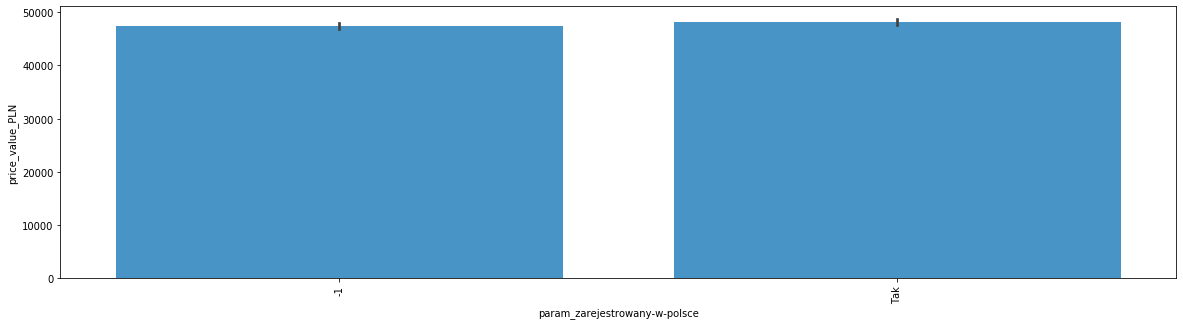

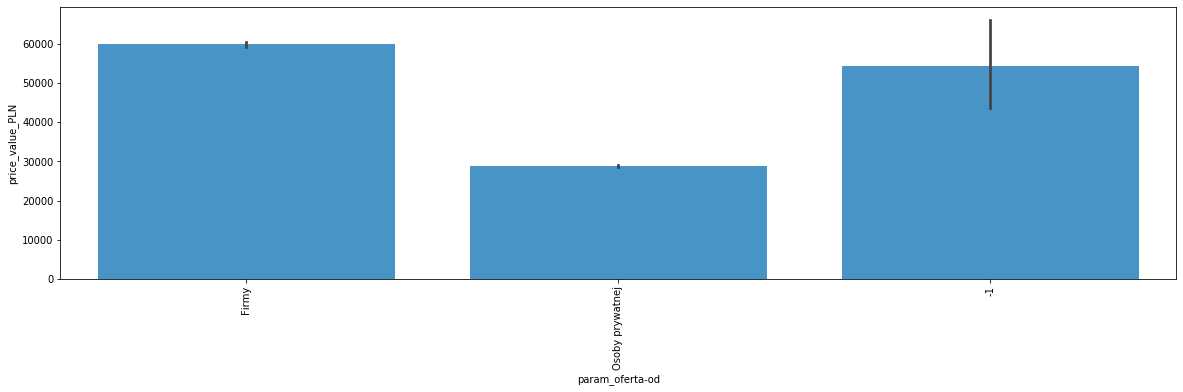

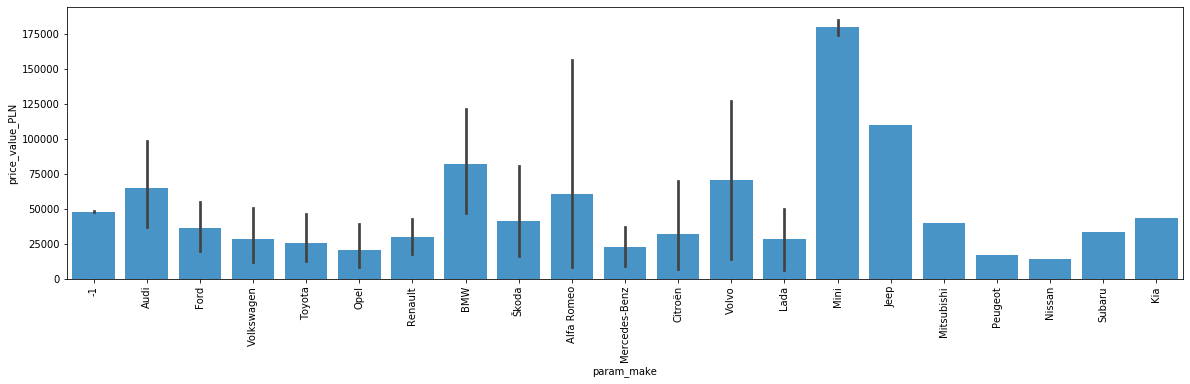

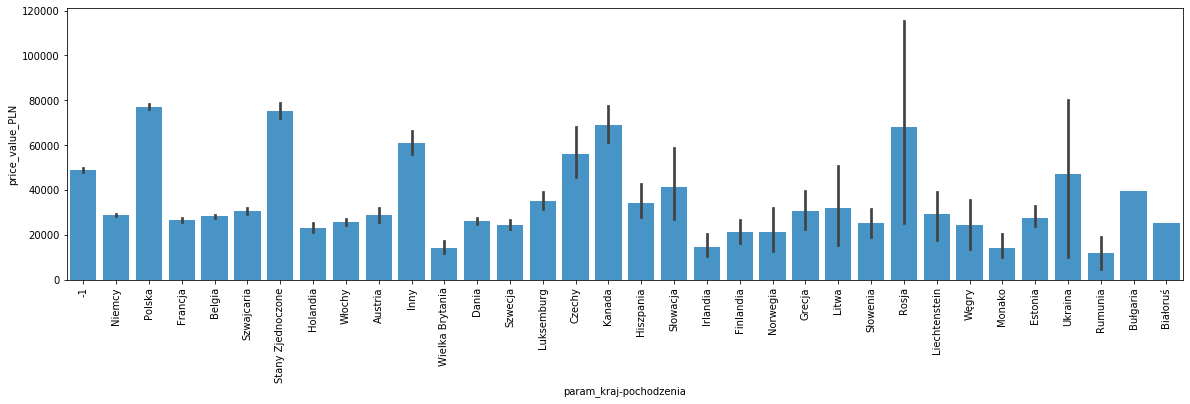

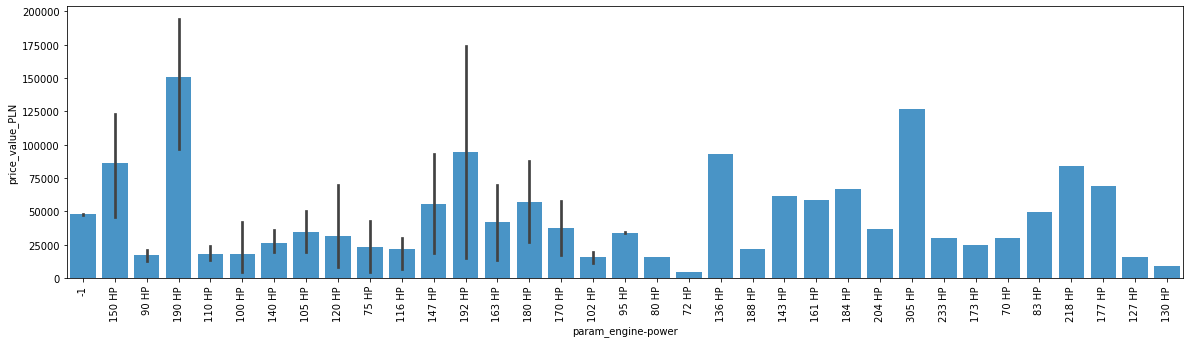

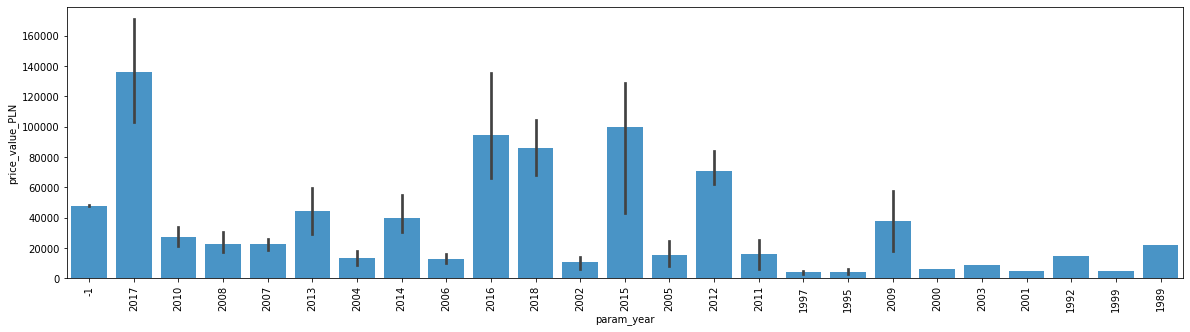

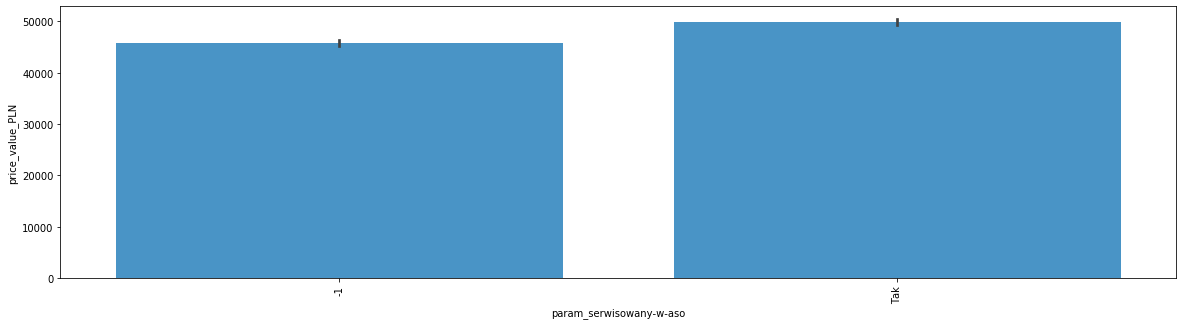

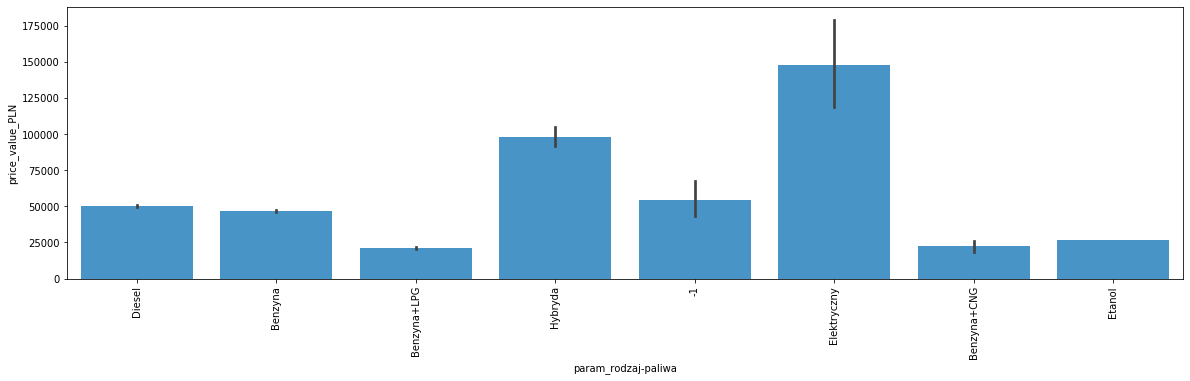

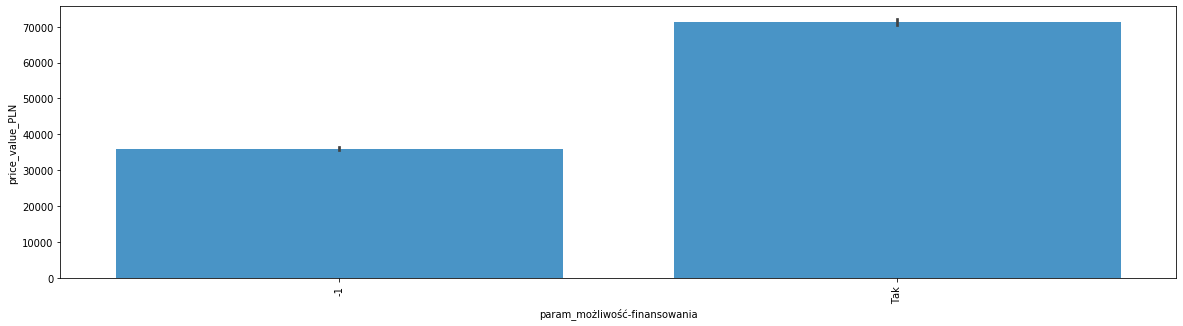

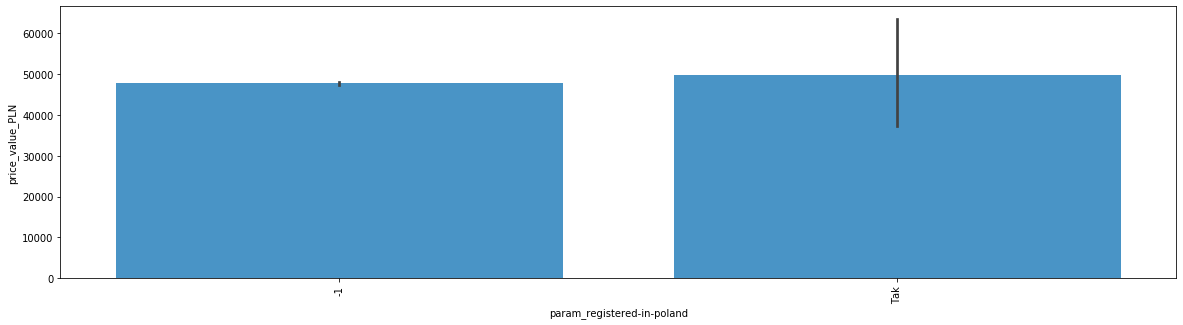

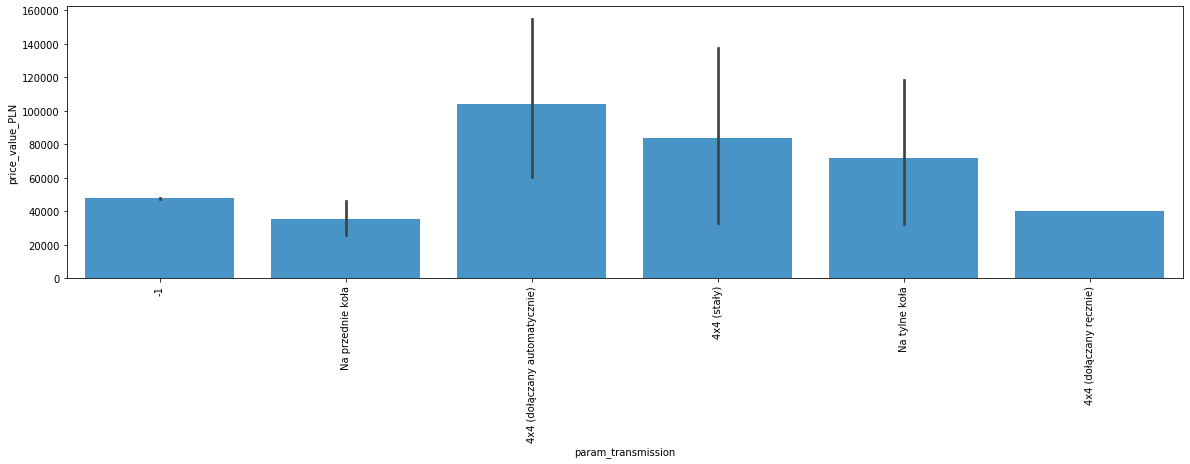

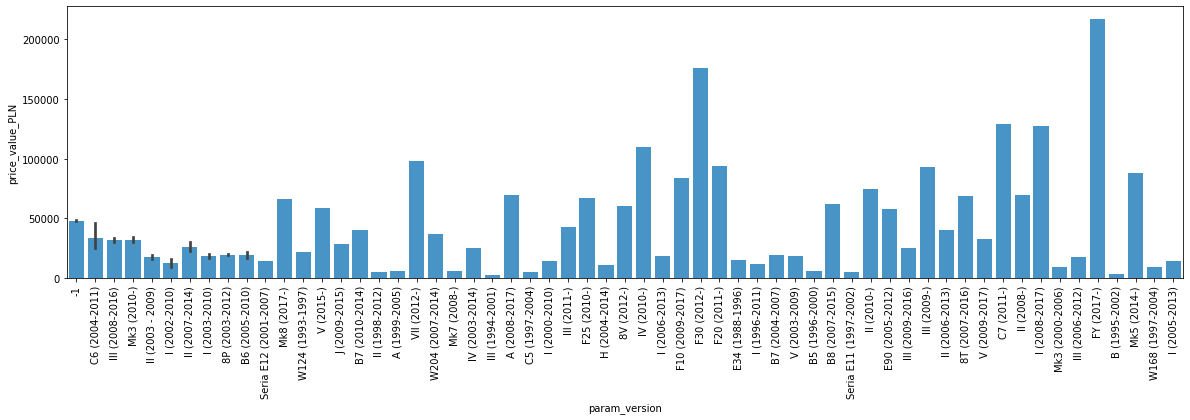

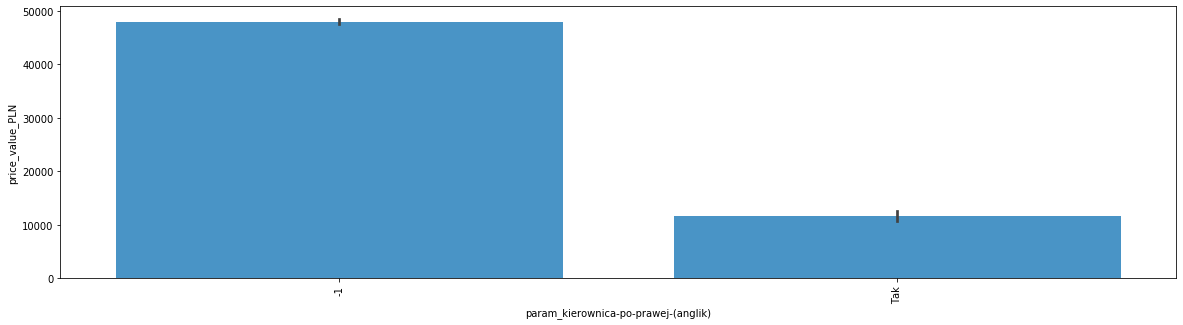

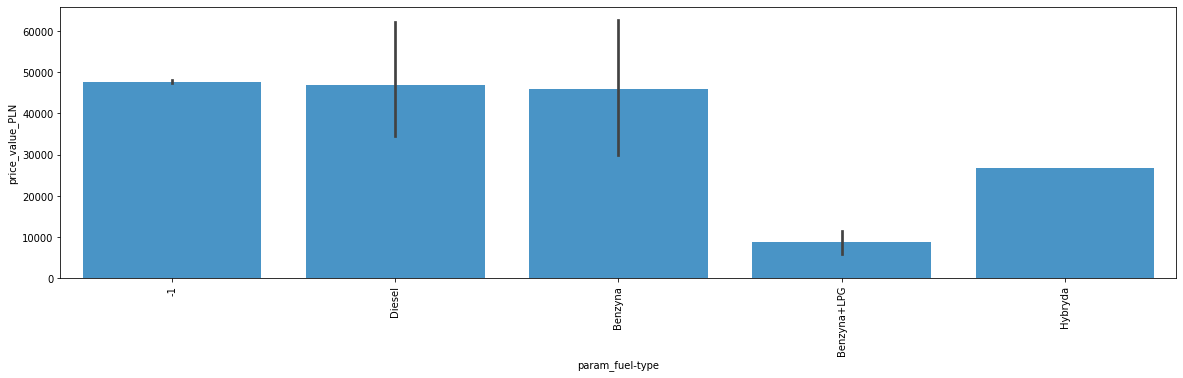

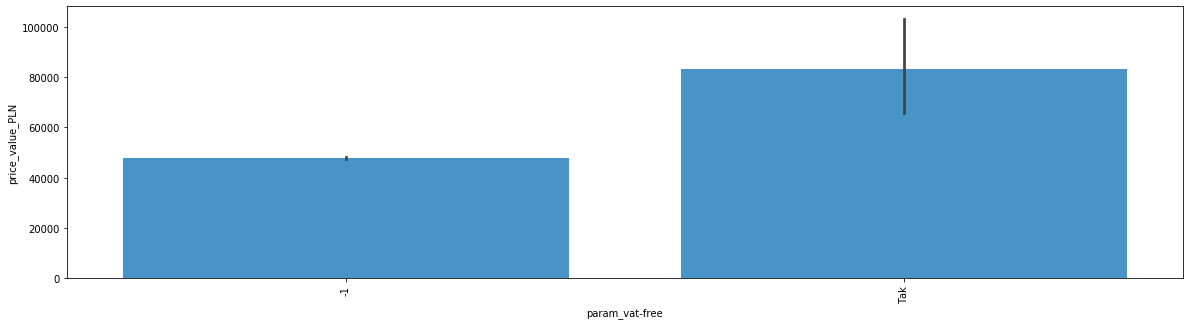

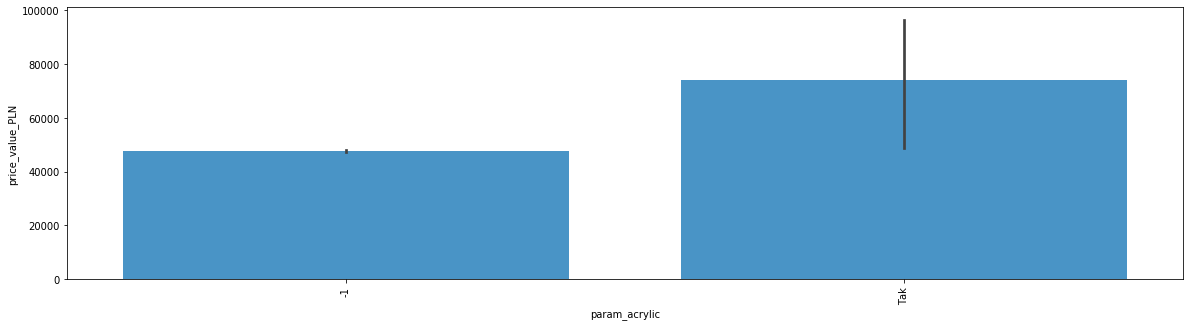

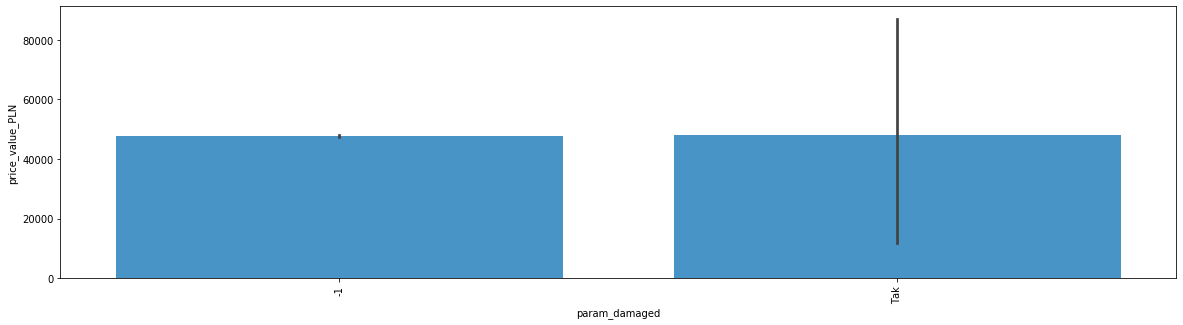

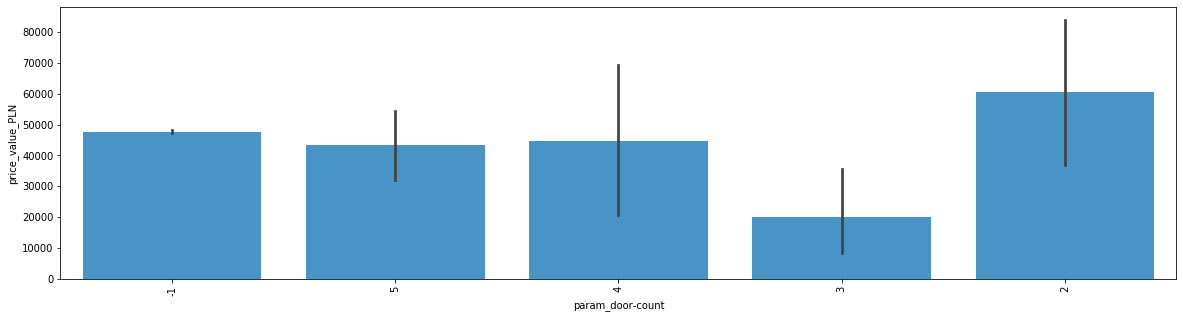

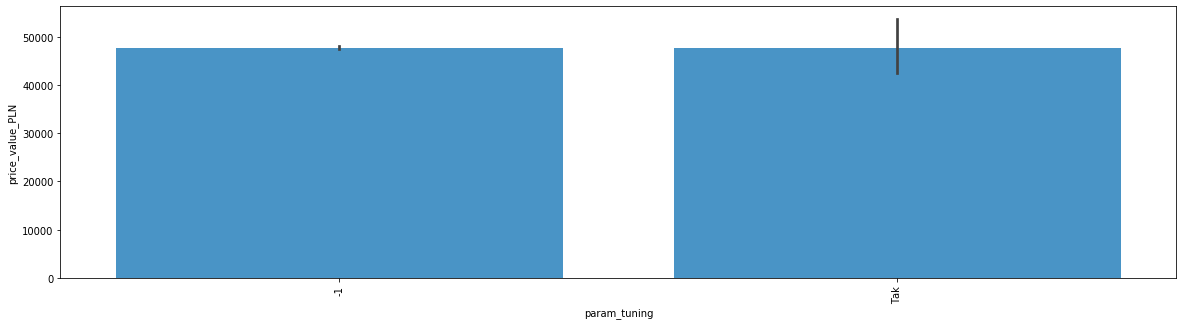

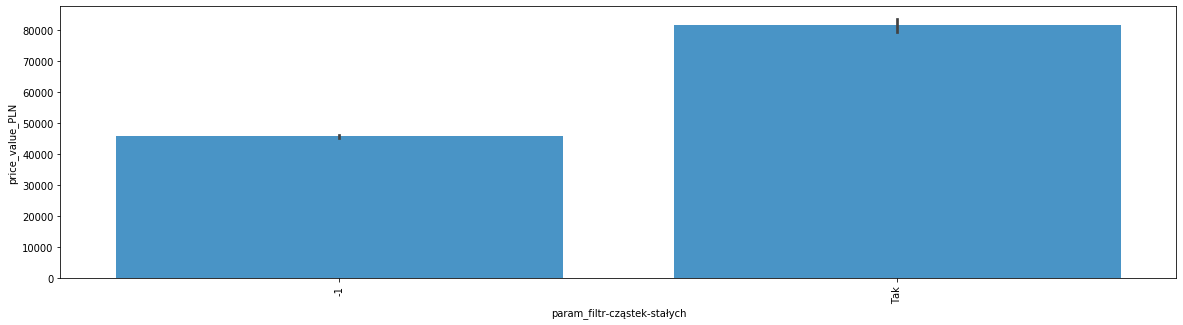

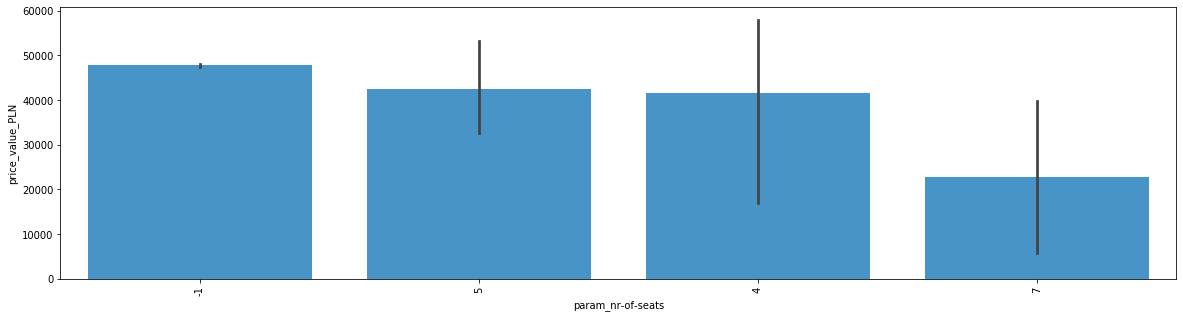

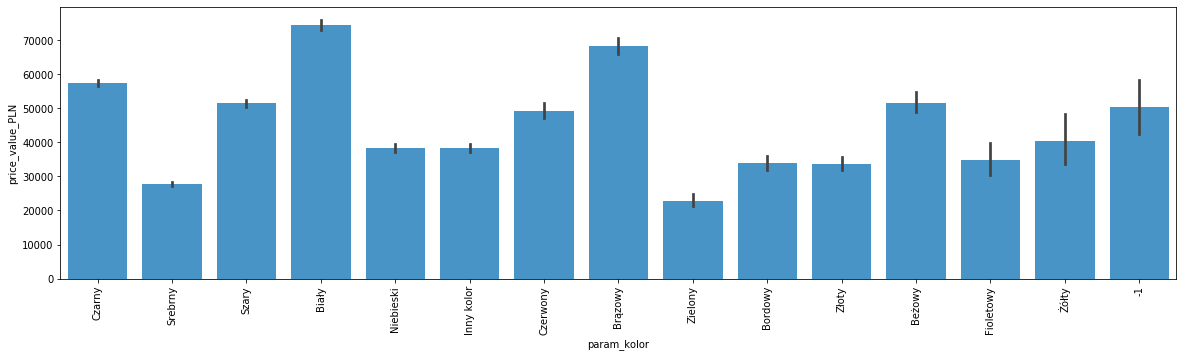

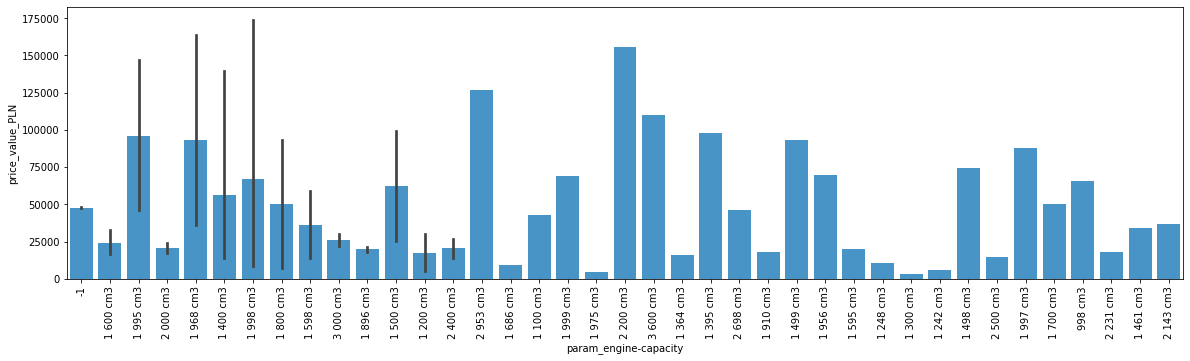

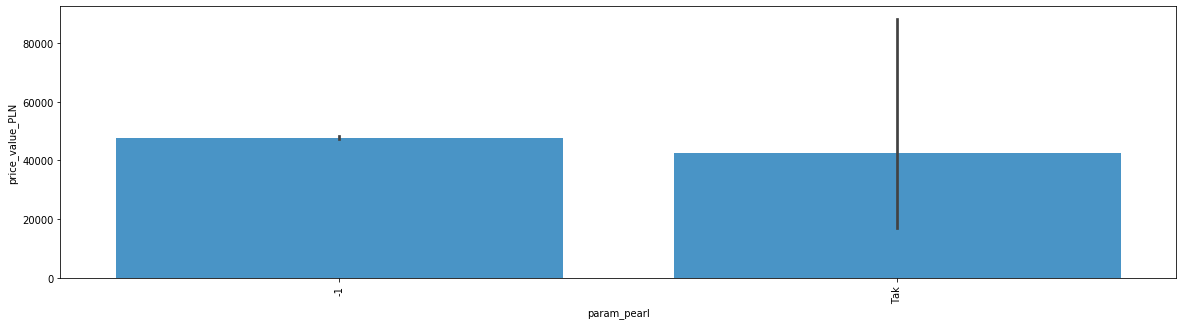

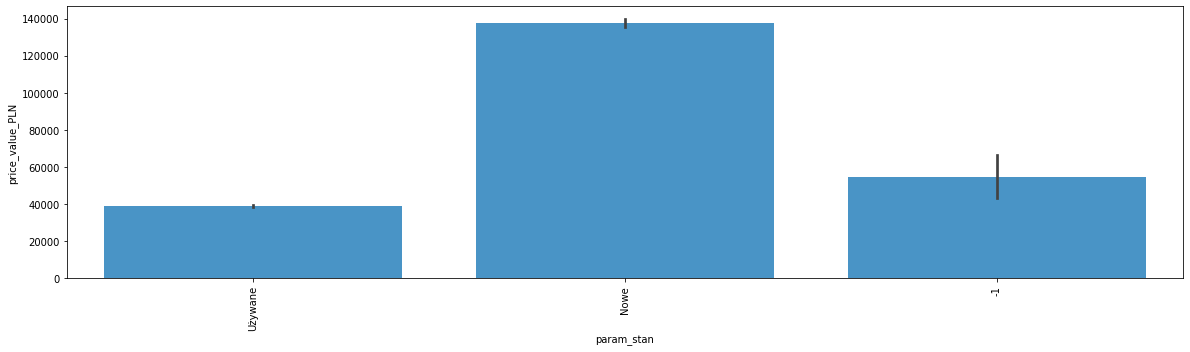

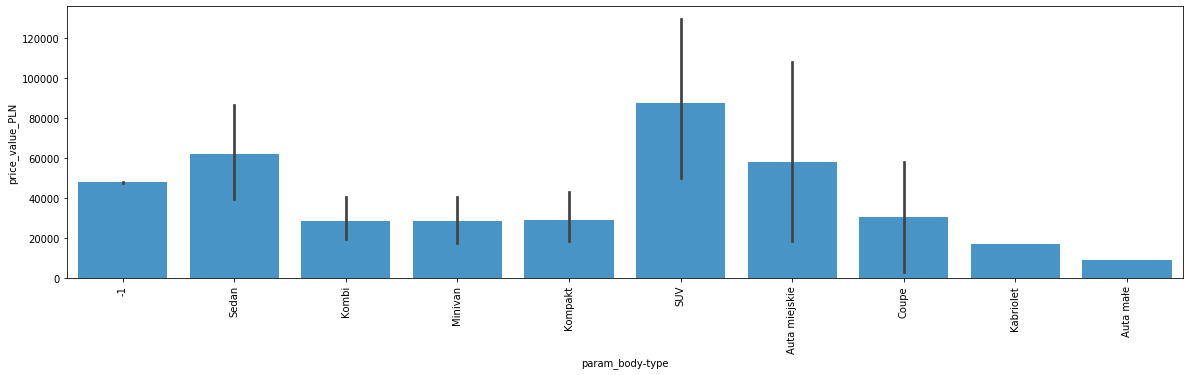

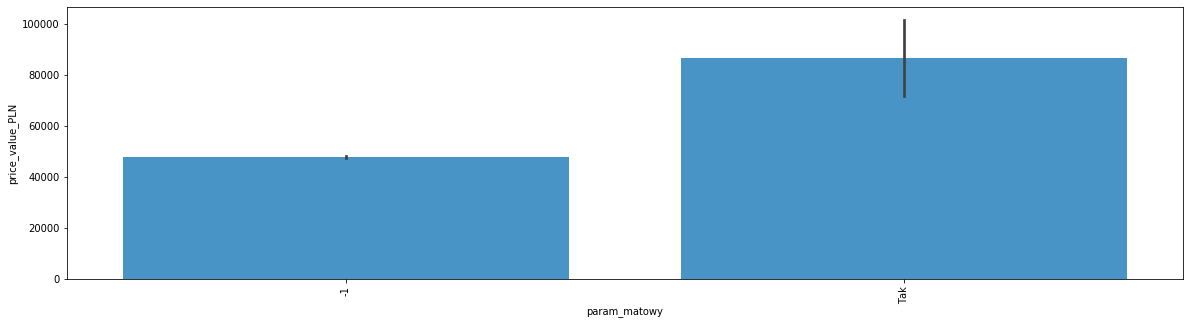

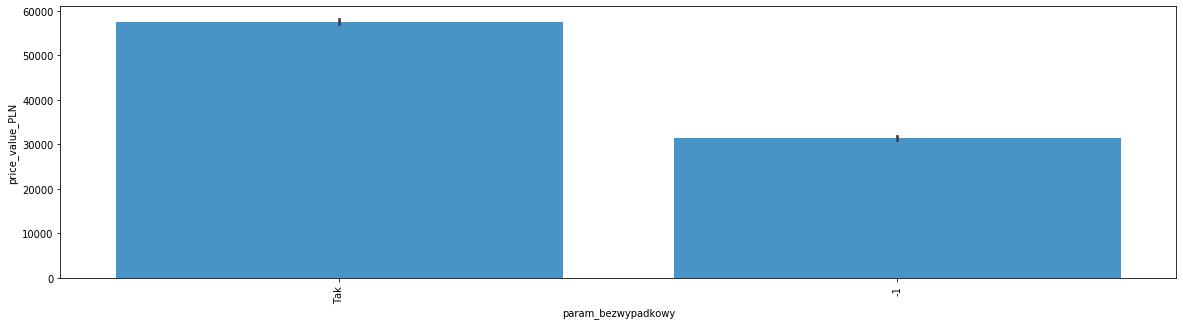

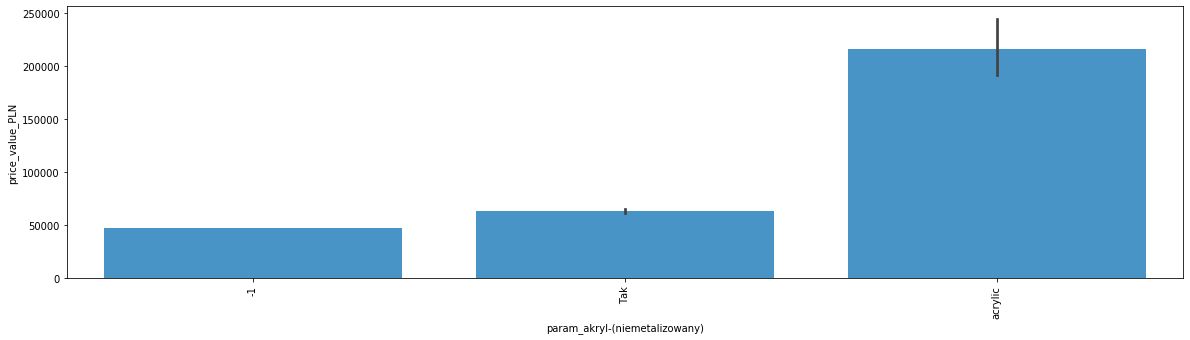

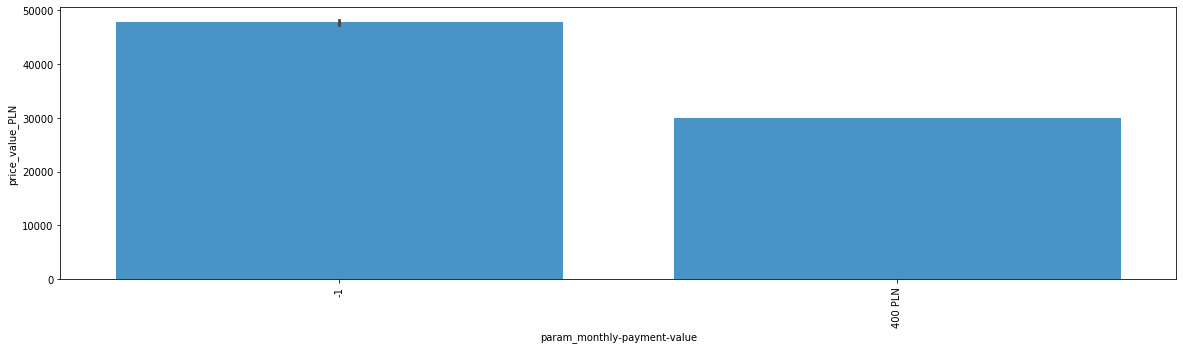

In [28]:
# plotting categorical features to look for potentially important ones
cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat', 'param_wersja__cat', 'param_model-pojazdu__cat']

for cat_feat in cat_feats:
    if cat_feat not in cat_no_plot:
        cat_name = cat_feat[:-len(cat_feat_prefix)]
        plt.figure(figsize=(20,5))
        sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
        plt.xticks(rotation=90);
        plt.show()

###### numerical features

In [29]:
# numerical features picked from df
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [30]:
df['param_engine-capacity'].unique()

array([-1, '1 600 cm3', '1 995 cm3', '1 364 cm3', '3 000 cm3',
       '2 200 cm3', '2 953 cm3', '1 598 cm3', '2 143 cm3', '1 700 cm3',
       '1 395 cm3', '2 500 cm3', '1 400 cm3', '1 200 cm3', '1 910 cm3',
       '1 997 cm3', '1 968 cm3', '1 896 cm3', '1 686 cm3', '2 698 cm3',
       '1 975 cm3', '2 400 cm3', '1 242 cm3', '1 998 cm3', '1 500 cm3',
       '2 231 cm3', '3 600 cm3', '2 000 cm3', '1 800 cm3', '1 595 cm3',
       '1 498 cm3', '1 100 cm3', '1 300 cm3', '998 cm3', '1 248 cm3',
       '1 956 cm3', '1 461 cm3', '1 499 cm3', '1 999 cm3'], dtype=object)

In [31]:
def get_rid_of_unit_and_dec(val): # getting rid of units, spaces between numbers and decimals
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val

In [32]:
# pulling numerical data from strings
num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)

num_feats = [x for x in df.columns if num_feat_prefix in x]

In [33]:
# model trained with bool, categorical and numerical features. Score significantly improved.
feats = list(bool_feats) + list(cat_feats) + list(num_feats)

get_X_y_and_cros_val(model, feats, log=False)

([14198.374124514627, 14763.79421947926, 14567.378956949546],
 234.38889941120257)

In [34]:
# Double checking with logarithmic target variable
get_X_y_and_cros_val(model, feats, log=True)

([43533.61941461478, 44240.73875922487, 43841.128269248155], 289.4953476692308)

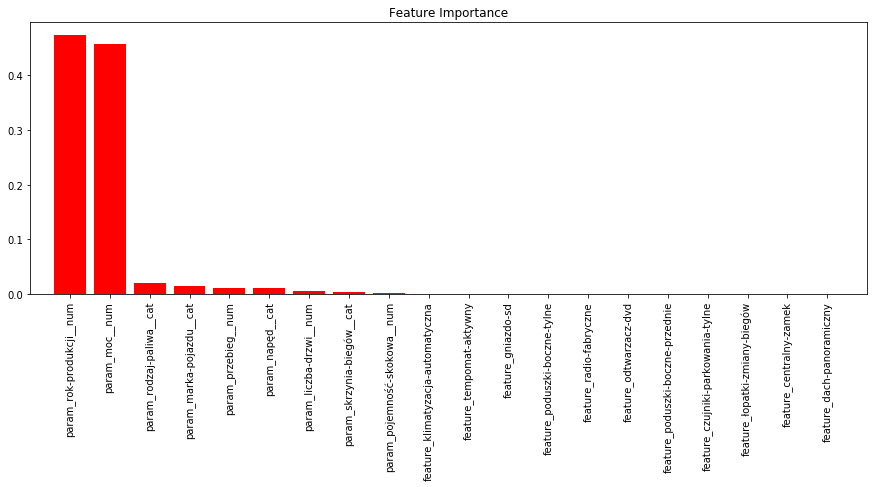

In [35]:
# after each iteration of feature engineering feature importance and permutation importance was checked
# to look for features worth working on in next iteration

X = df[ feats ]
y = df['price_value_PLN']
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

In [36]:
imp = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.7121 ± 0.0083,param_rok-produkcji__num
0.5755 ± 0.0041,param_moc__num
0.0375 ± 0.0029,param_rodzaj-paliwa__cat
0.0247 ± 0.0017,param_przebieg__num
0.0238 ± 0.0027,param_marka-pojazdu__cat
0.0222 ± 0.0003,param_napęd__cat
0.0086 ± 0.0002,param_skrzynia-biegów__cat
0.0078 ± 0.0014,param_liczba-drzwi__num
0.0047 ± 0.0001,param_pojemność-skokowa__num
0 ± 0.0000,feature_immobilizer


# Model selection and optimization

In [69]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
# feats = ['param_rok-produkcji__num','param_moc__num','param_rodzaj-paliwa__cat','param_przebieg__num','param_marka-pojazdu__cat','param_napęd__cat','param_skrzynia-biegów__cat','param_liczba-drzwi__num','param_pojemność-skokowa__num']

In [68]:
# Since using logarithm of target vartiable did not bring results
# all models will be tested on the same set of features using standard 3 fold cross_val_score
def get_X_y():
    return df[ feats ], df['price_value_PLN']

def test_model(model):
    X, y = get_X_y()
    
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return np.abs(np.mean(scores)), np.std(scores)

def plot_fi_lc_e5(model, pi=True, lc=True, e5=False):
    X, y = get_X_y()
    model.fit(X, y)
    
    if pi == True:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    if lc == True:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');
    if e5 == True:
        imp = PermutationImportance(model, random_state=0).fit(X,y)
        return eli5.show_weights(imp, feature_names=feats)

In [40]:
# Testing decision Tree
model = DecisionTreeRegressor(max_depth=10, random_state=0)
test_model(model)

(10876.154516893592, 55.372783128649544)

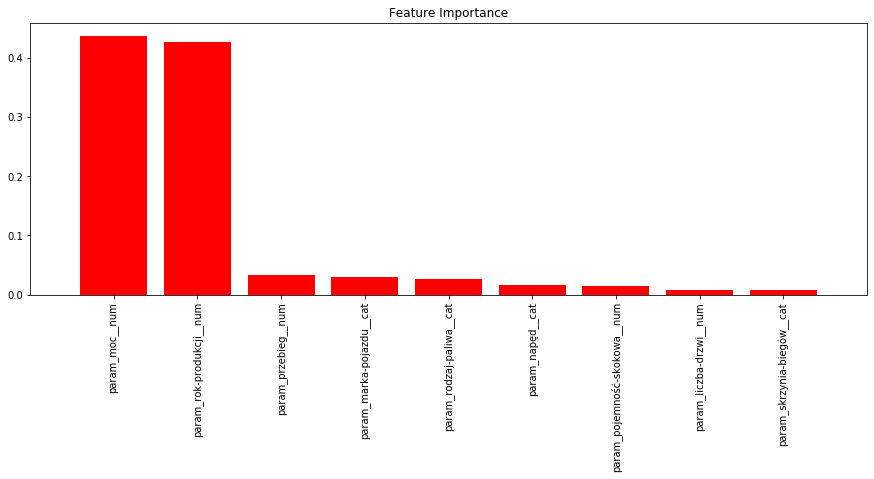

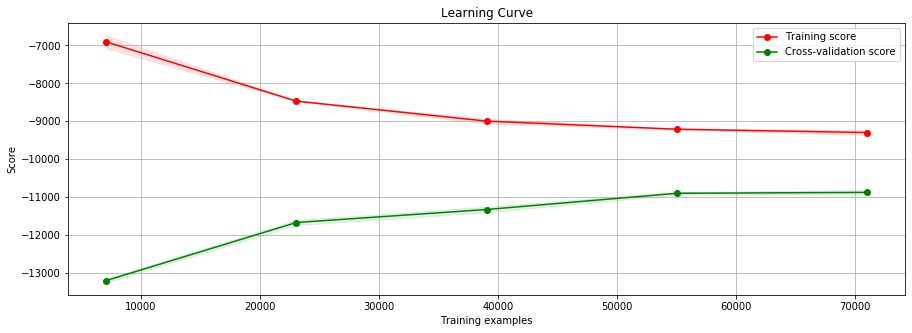

In [41]:
plot_fi_lc_e5(model, True, True, False)

In [42]:
# Testing Random Forest
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
test_model(model)

(9813.759315494382, 30.408995876291403)

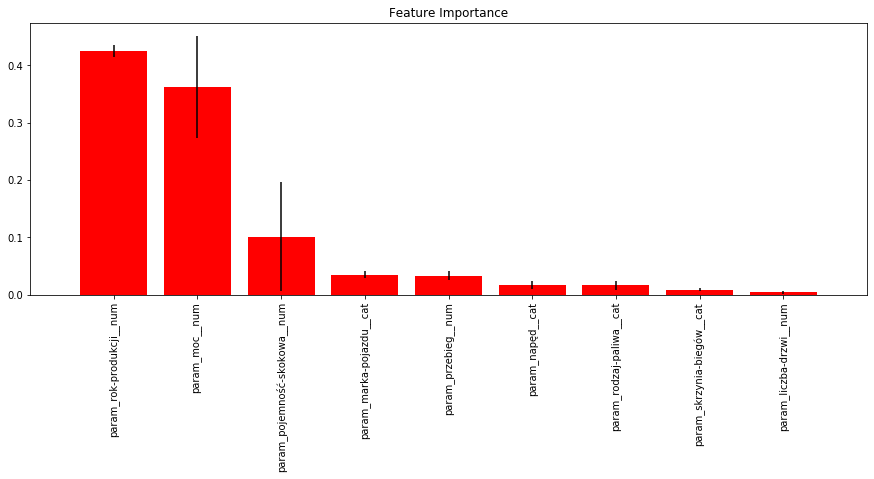

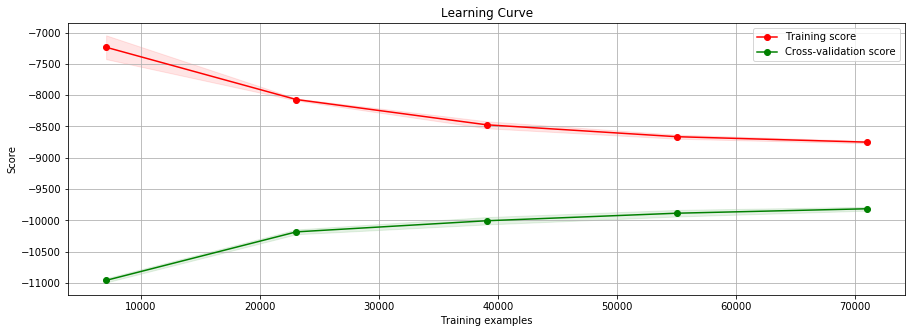

In [43]:
plot_fi_lc_e5(model, True, True, False)

In [44]:
# testing XGB regressor
xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

model = xgb.XGBRegressor(**xgb_params)
test_model(model)

(8633.77503847034, 54.072204890929505)

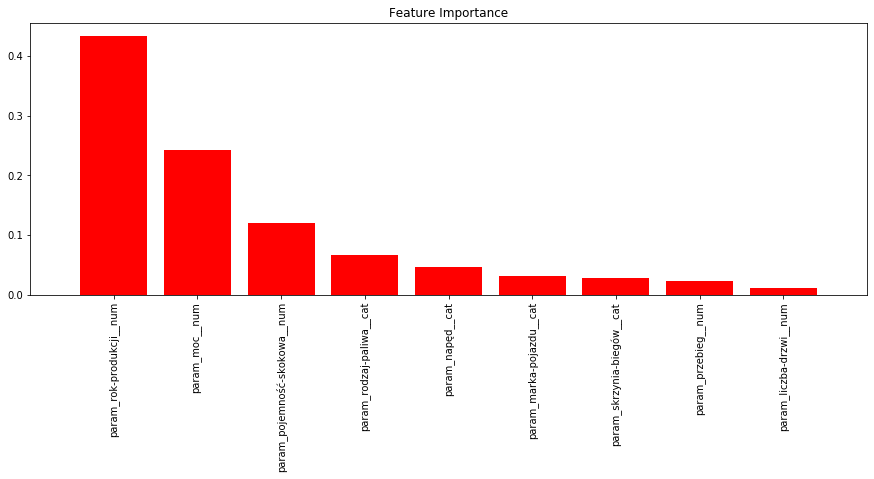

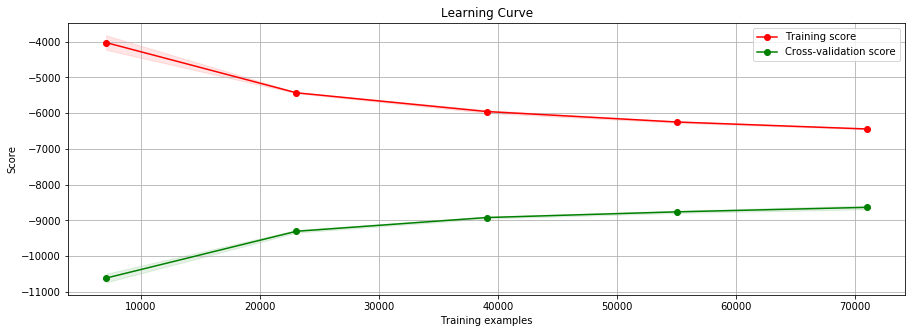

In [45]:
plot_fi_lc_e5(model, True, True, False)

In [70]:
# Since XBG looks most promising it gets hyper optimized

X = df[feats].values
y = df['price_value_PLN'].values

def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'seed':0
    }

    print('training wiht params: {}'.format(xgb_params))
    model = xgb.XGBRegressor(**xgb_params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))

    print(scores)
    print('final_score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

training wiht params: {'max_depth': 17, 'learning_rate': 0.08488585657116061, 'colsample_bytree': 0.8068611482100002, 'subsample': 0.8373293042834691, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6467.13498077 -6593.33476853 -6487.7247291 ]        
final_score: 6516.064826136911                        

training wiht params: {'max_depth': 15, 'learning_rate': 0.16685220214049018, 'colsample_bytree': 0.8510510442180127, 'subsample': 0.9652457847509797, 'min_child_weight': 8, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6699.59275562 -6871.87681575 -6750.00911365]                                  
final_score: 6773.82622834027                                                   

training wiht params: {'max_depth': 19, 'learning_rate': 0.1738487773117356, 'colsample_bytree': 0.8464074420073125, 'subsample': 0.7093890780762139, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6861.494

[-6519.00096745 -6654.7313176  -6590.42111048]                                  
final_score: 6588.0511318433455                                                 

training wiht params: {'max_depth': 17, 'learning_rate': 0.11895022896216509, 'colsample_bytree': 0.9269883452370571, 'subsample': 0.8063911506653507, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6678.83351381 -6809.11513617 -6658.47116635]                                  
final_score: 6715.473272113184                                                  

training wiht params: {'max_depth': 17, 'learning_rate': 0.07849202174963588, 'colsample_bytree': 0.9560114893392067, 'subsample': 0.8643388140409833, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0}
[-6565.95700785 -6746.13929863 -6571.83004339]                                   
final_score: 6627.975449959283                                                   

training wiht params: {'max_dep

In [71]:
# checking hyperopt parameters

xgb_params_opt = {'colsample_bytree': 0.8068611482100002,
                  'learning_rate': 0.08488585657116061,
                  'max_depth': 17,
                  'min_child_weight': 2,
                  'subsample': 0.8373293042834691,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = xgb.XGBRegressor(**xgb_params_opt)

In [72]:
test_model(model)

(6516.064826136911, 55.28090346907524)

In [ ]:
plot_fi_lc_e5(model, True, True, False)

In [51]:
# model seems to be a bit over fitted so parameters were changed to:
xgb_params_opt = {'colsample_bytree': 0.7, 
                  'learning_rate': 0.095, 
                  'max_depth': 10, 
                  'min_child_weight': 8, 
                  'subsample': 0.8, 
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = xgb.XGBRegressor(**xgb_params_opt)
test_model(model)

(8543.80194575773, 67.0899381215423)

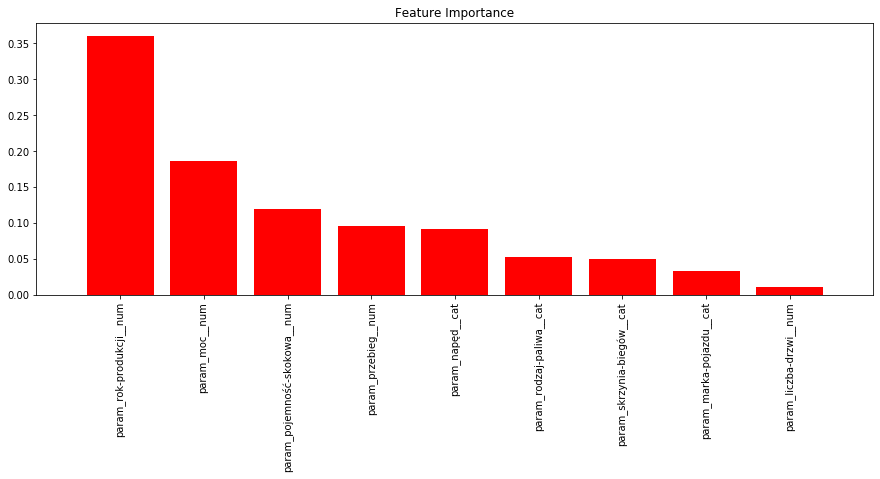

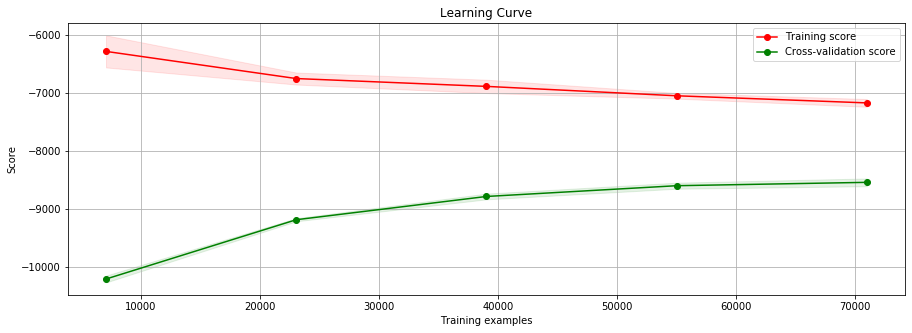

In [52]:
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');